#  <center>Written Report - 6.419x Module 4 </center>
## <center>Time Series Analysis </center>

<h3 style='text-align: right;'> kayal_t_vizhi </h3>

The goal of this problem is to analyze the CPI and BER data for the last decade. The CPI (consumer price index, the price of a "market basket of consumer goods and services" - a proxy for inflation) is released monthly by the Bureau of Labor Statistics, and is given in CPI.csv. The file T10YIE.csv lists (during most of the same time period) the break-even rate (BER) , or the difference in yield between a fixed rate and inflation adjusted 10 year treasury note. This difference can be interpreted as what the market views will be the inflation rate for the next 10 years, on average.

There is more than a decade of data in CPI.csv. For your results to the problems below, report the mean squared prediction error for 1 month ahead forecasts starting September 2013. For example, to predict the  in May 2015, you can use all the data before May 2015. You should perform all of your model fitting on the months prior to September 2013, and use the remaining months for evaluation.

In [1]:
%run imports.ipynb

## Problem 5: Converting to Inflation Rates

### <i> __5.1.i (1 points)__
Description of how you compute the monthly inflation rate from $CPI$ and a plot of the monthly inflation rate. (You may choose to work with log of the $CPI$.)
    
#### **Solution:** 
<h5> 1. Compute monthly inflation rates </h5>
    I resampled the dates by the average of each month. This was a convinient method compared to directly applying the formula.  

In [2]:
# load csv as a DataFrame
source = 'CPI.csv'
cpi = pd.read_csv(source)

# convert date column datatype to datetime
cpi['date'] = pd.to_datetime(cpi['date'], format='%m/%d/%Y')

# set date column as index
cpi = cpi.set_index('date')

# resample data by month 
cpi_monthly = cpi.resample('M').mean()

cpi_monthly.index = cpi_monthly.index.to_period('M')

# reset indices to integers 
cpi_monthly = cpi_monthly.reset_index()

cpi_monthly.head()

,date,CPI
0,2008-07,100.00000
1,2008-08,100.52510
2,2008-09,100.12380
3,2008-10,99.98538
4,2008-11,98.97539


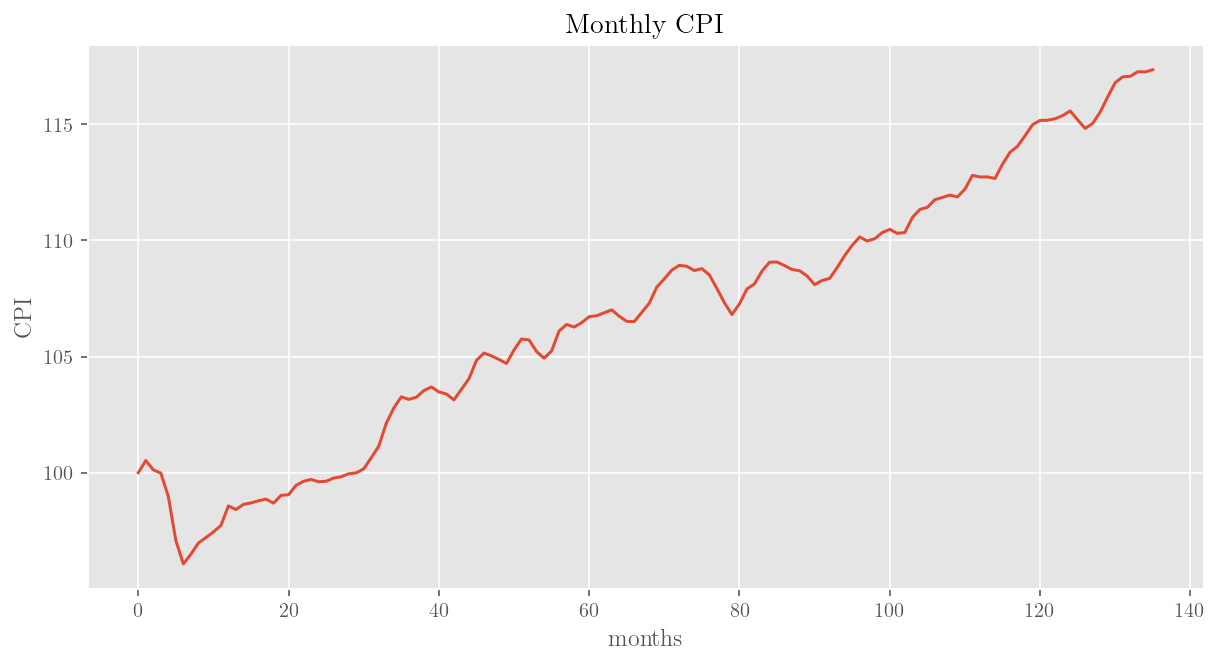

In [4]:
plt.plot(cpi_monthly['CPI'])
plt.xlabel('months')
plt.ylabel('CPI');
plt.title('Monthly CPI');

<h5>2. Plot monthly inflation rates

In [5]:
a = np.zeros_like(cpi_monthly['CPI'])
for i in range(1, len(cpi_monthly.index)):
    a[i] = (cpi_monthly['CPI'][i] - cpi_monthly['CPI'][i-1]) / cpi_monthly['CPI'][i-1]
a[-1] = np.nan
cpi_monthly['MIR'] = a * 100

In [6]:
# split into train and test data
train_cpi =  cpi_monthly[cpi_monthly['date'] < '2013-09-01'].copy()
test_cpi =  cpi_monthly[cpi_monthly['date'] >= '2013-09-01'].copy().dropna()

In [7]:
# X_train values : t = {0, 1, 2, ... , 61}
X_train = pd.DataFrame(train_cpi.index, columns = ['t'])
y_train = train_cpi['CPI']

# X_test values : t = {62, 63, ... 136}
X_test = pd.DataFrame(test_cpi.index, columns = ['t'])
y_test = test_cpi['CPI']

# fit linear regression model
reg = LinearRegression().fit(X_train, y_train)

print(f'slope: {reg.coef_}')
print(f'intercept: {reg.intercept_}')

slope: [0.16104348]
intercept: 96.72932632872502


<h5> 2. Plot trend

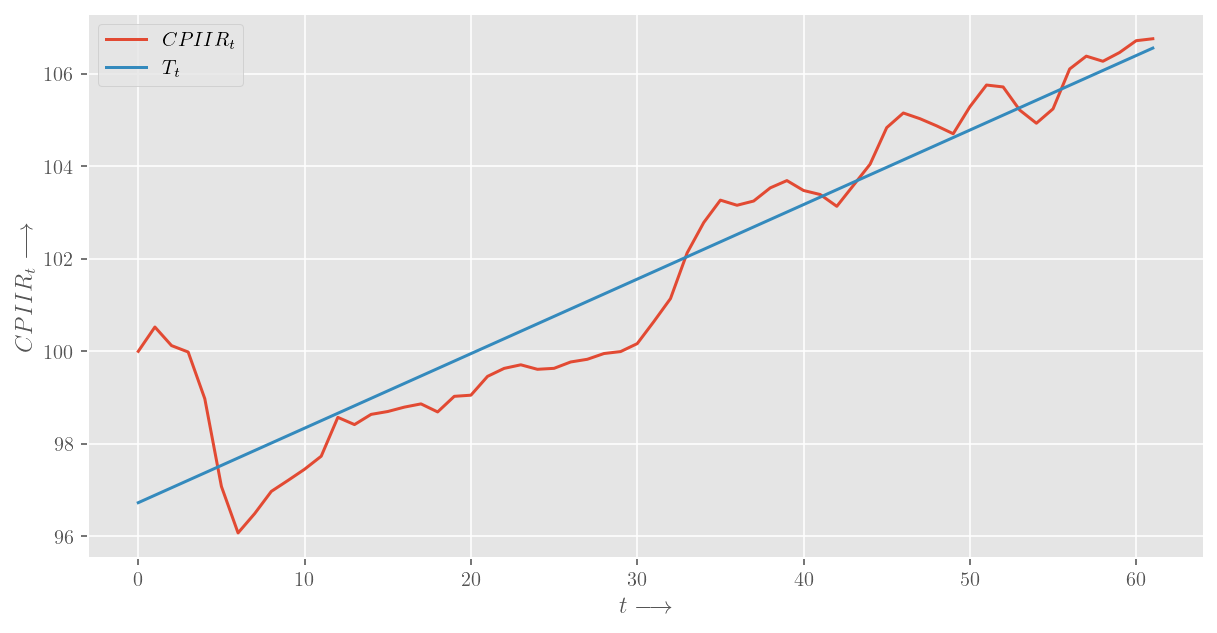

In [8]:
plt.plot(y_train, label=r'$CPI IR_t$')
plt.plot(reg.predict(X_train), label = r'$T_t$')


plt.xlabel(r'$t \longrightarrow$')
plt.ylabel(r' $ CPI IR_t \longrightarrow$')
plt.legend()

plt.show();

<h5> 3. Compute residuals

In [9]:
test_cpi['residual'] = y_test - reg.predict(X_test)
train_cpi['residual'] = y_train - reg.predict(X_train)

<h5> 4. Plot detrended values of training data </h5>

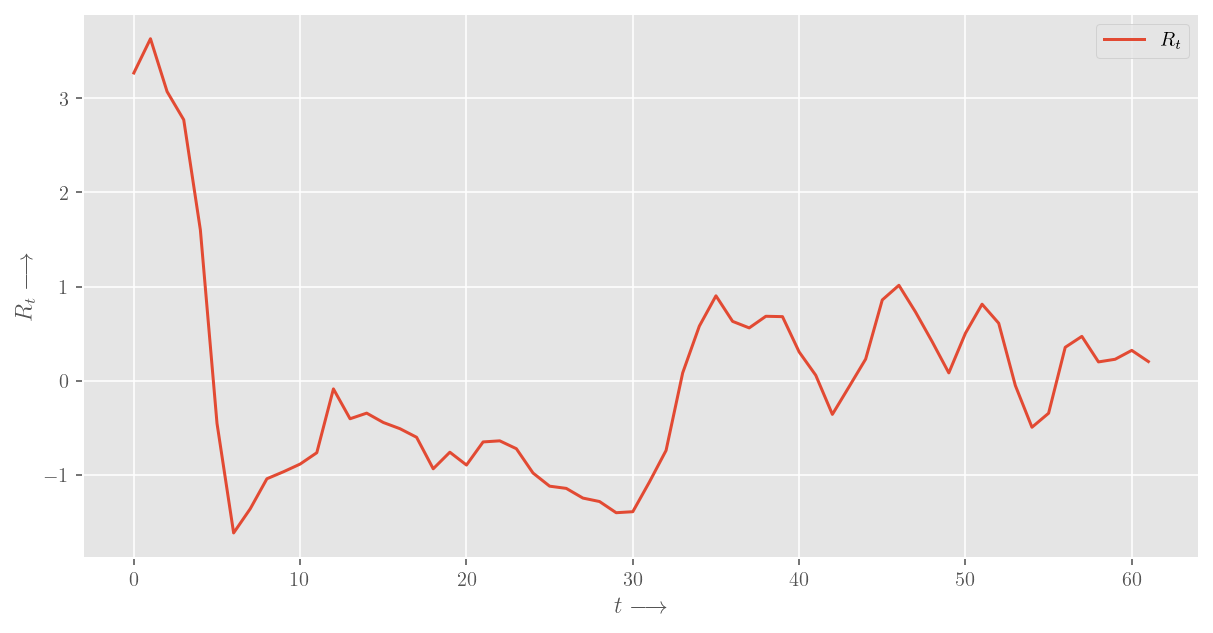

In [10]:
plt.plot(train_cpi['residual'] , label = r'$R_t$')
plt.xlabel(r'$t \longrightarrow$')
plt.ylabel(r'$R_t \longrightarrow$')
plt.legend()

plt.show();

In [21]:
max_residual = train_cpi['residual'].max()
print(f'Max residual value {round(max_residual, 5)}')

Max residual value 3.63473


The detrended data does not appear to have any seasonal components so we proceed to fit AR model

### <i> __5.1.iii (3 points)__
<i>Statement of and justification for the chosen $AR(p)$ model. Include plots and reasoning. </i>
    
#### **Solution:** 
The effect of each previous observation can be determined using the autocorrelation plot and partial autocorrelation plot for the autoregressive model.
<h5> 1. Analysing Partial Autocorrelation plot</h5>
From the plot it can be seen that there is significant correlation upto lag $p=2$. Therefore I used an $AR(1)$ model for the analysis.

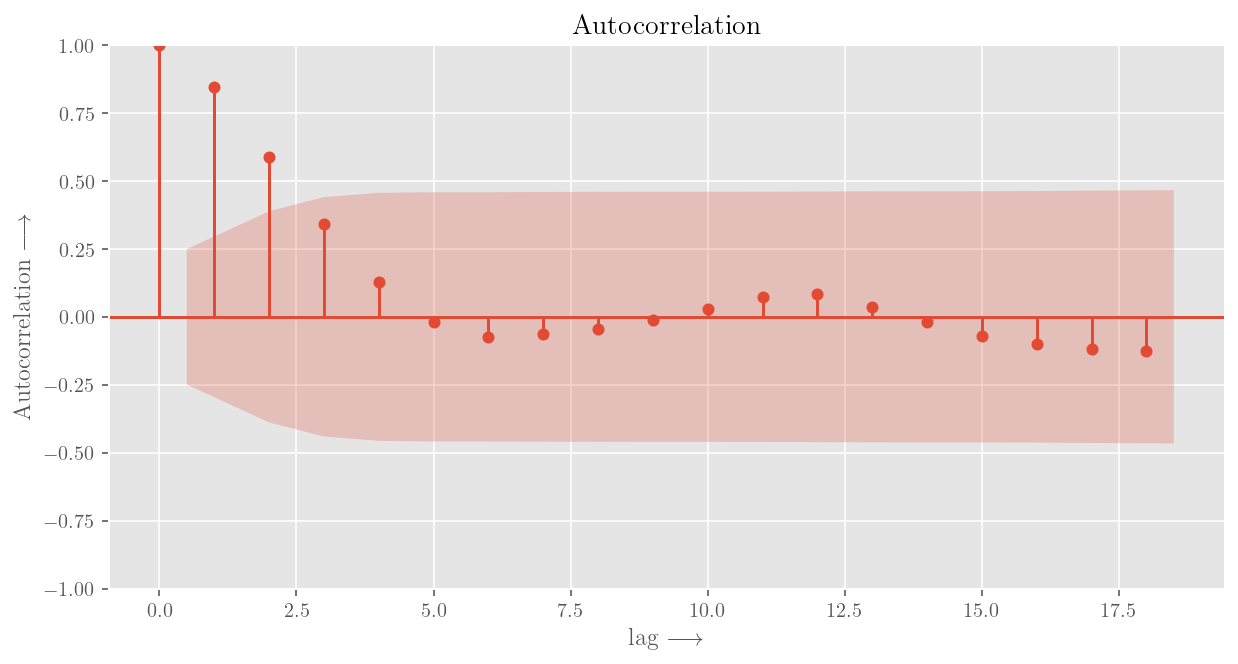

In [13]:
plot_acf(train_cpi['residual'])

plt.ylabel(r'Autocorrelation $\longrightarrow$')
plt.xlabel(r'lag $\longrightarrow$')
plt.show()

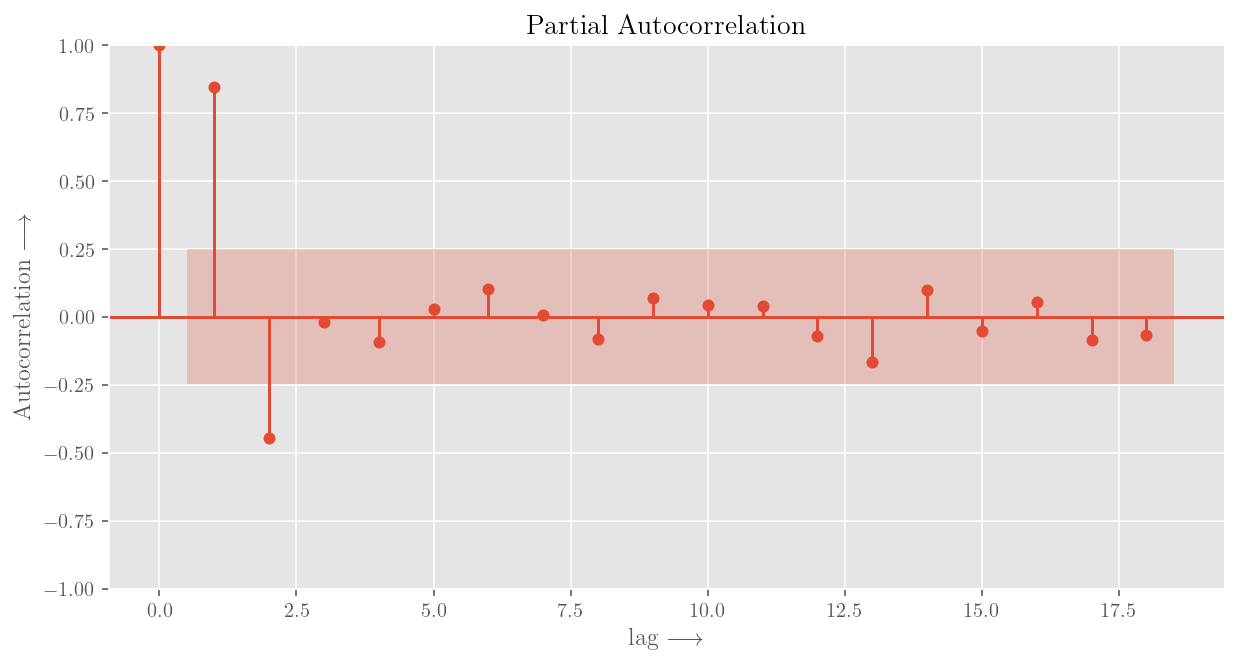

In [11]:
plot_pacf(train_cpi['residual'], method='ywm',)

plt.ylabel(r'Autocorrelation $\longrightarrow$')
plt.xlabel(r'lag $\longrightarrow$')
plt.show()

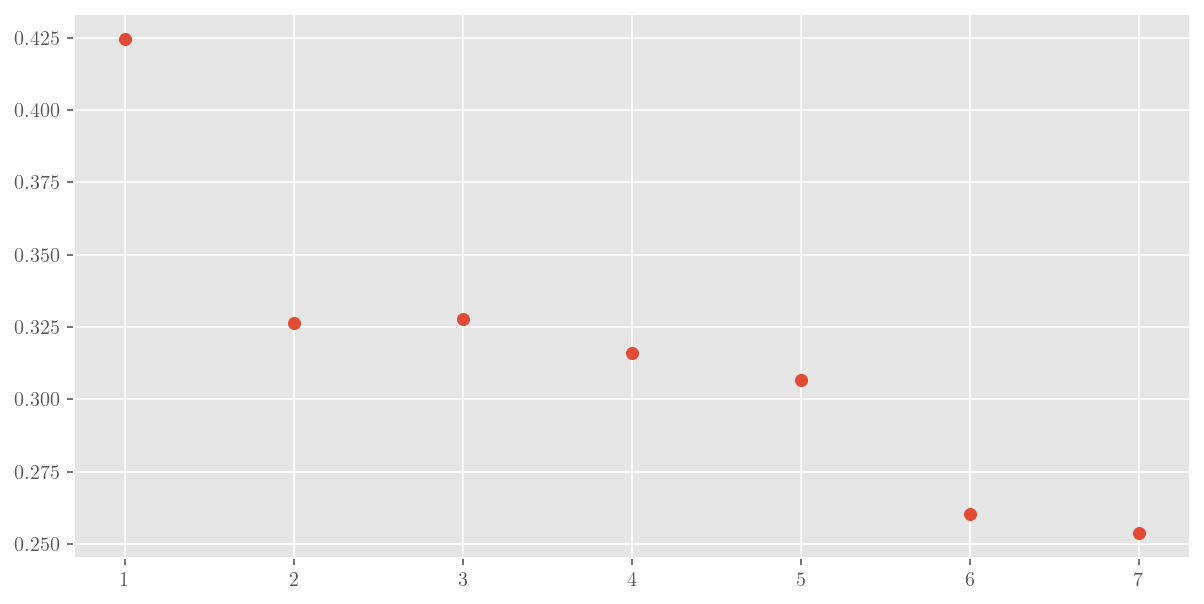

In [29]:
rmse_train = []

for n in range(1, 8):
    model = AutoReg(train_cpi['residual'],
                    lags=n,
                    trend='n' # no trend
                   )
    model_fit = model.fit()
    predictions = model_fit.predict()
    rmse = (mean_squared_error(train_cpi['residual'][n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

plt.scatter(np.arange(1, 8), rmse_train);

### <i> __5.1.iv (3 points)__
<i>Description of the final model; computation and plots of the 1 month-ahead forecasts for the validation data. In your plot, overlay predictions on top of the data. </i>
    
#### **Solution:** 
The $t^{th}$  term of  $AR(2)$ model is given by,
\begin{equation}
    X_{t}=\phi _{1}X_{{t-1}}+\phi _{2}X_{{t-2}}+\varepsilon _{t}.
\end{equation}
<h5> 1. Fitting Autoregressive model of order 2 

In [30]:
model = AutoReg(train_cpi['residual'], lags=2)
model_fit = model.fit()
coef = model_fit.params
coef

const         -0.043105
residual.L1    1.323666
residual.L2   -0.530797
dtype: float64

The model is given by,
\begin{equation}
X_{t}=1.323666X_{{t-1}}+-0.530797X_{{t-2}}-0.043105
\end{equation}

<h5> 2. Computation of 1-month ahead forecast for validation set

In [39]:
# take two residuals from the training set for the first two predictions in test set
residuals = train_cpi['residual'][-2:].append(test_cpi['residual']).tolist()
pred = []

for i in range(2, len(residuals)):
    pred.append(coef[0] + coef[1]*residuals[i-1] + coef[2]*residuals[i-2])


In [40]:
test_cpi['trend'] = reg.predict(X_test)

test_cpi['predictions'] = pred + test_cpi['trend']

<h5> 3. Plot of 1-month ahead forecast for validation set

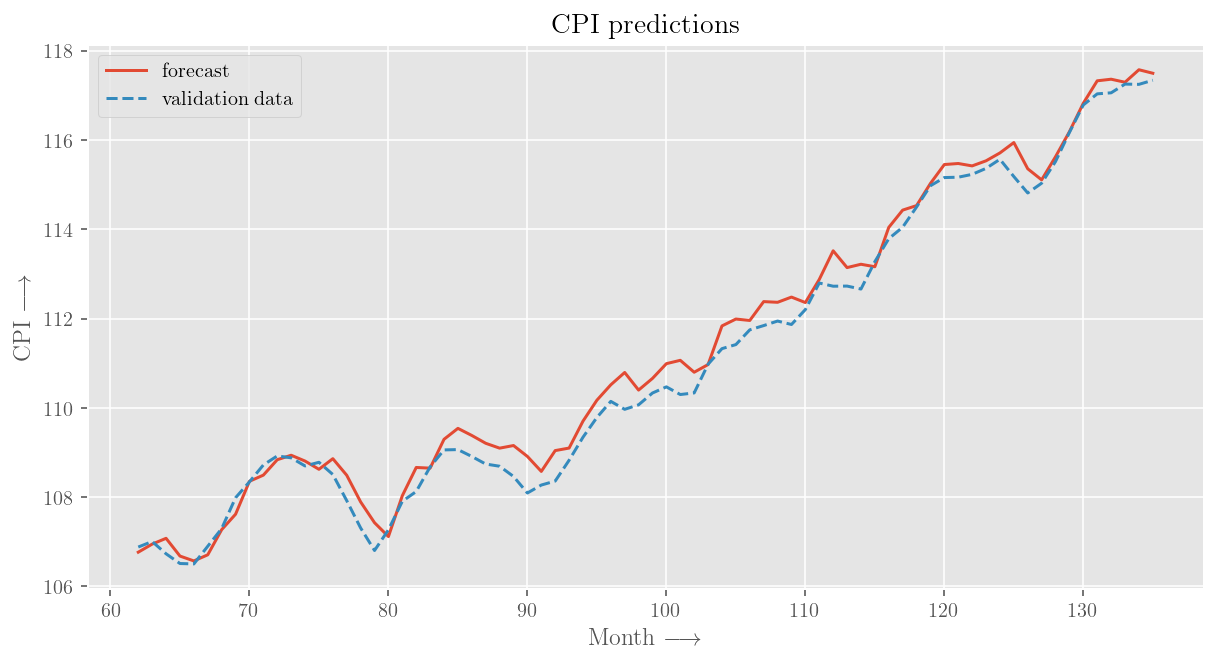

In [43]:
plt.plot(test_cpi['predictions'], label='forecast')
plt.plot(test_cpi['CPI'],'--', label='validation data' )
plt.xlabel(r'Month $\longrightarrow$')
plt.ylabel(r' CPI $\longrightarrow$')
plt.title('CPI predictions')

plt.legend()
plt.show();

In [42]:
mean_squared_error(test_cpi['CPI'], test_cpi['predictions'], squared=False)

0.39104043069964695

## Monthly Inflation rate

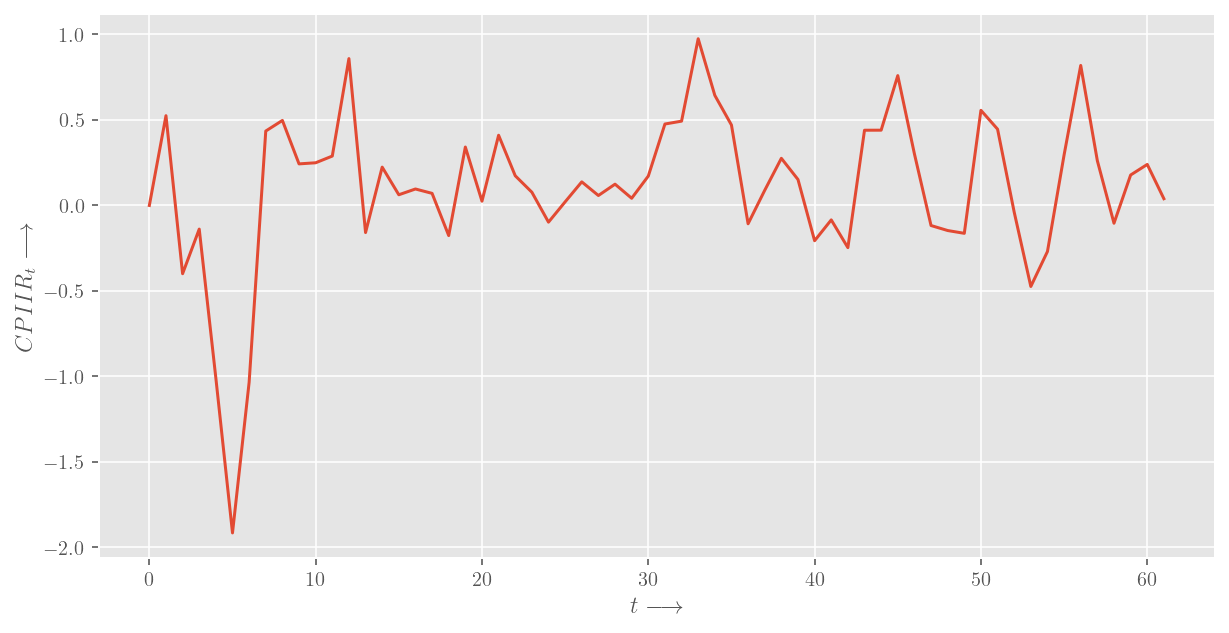

In [77]:
# plot CPI upto September 2013
plt.plot(train_cpi['MIR'])

#labels
plt.xlabel(r'$t \longrightarrow$')
plt.ylabel(r' $CPIIR_t \longrightarrow$')


plt.show();

### <i> __5.1.ii (2 points)__
Description of how the data has been detrended and a plot of the detrended data. </i>
    
#### **Solution:** 
I detrended the data by fitting a linear regression model on the training data as shown below
<h5> 1. Fit linear regression model to indentify trend

In [78]:
# X_train values : t = {0, 1, 2, ... , 61}
X_train = pd.DataFrame(train_cpi.index, columns = ['t'])
y_train = train_cpi['MIR']

# X_test values : t = {62, 63, ... 136}
X_test = pd.DataFrame(test_cpi.index, columns = ['t'])
y_test = test_cpi['MIR']

# fit linear regression model
reg = LinearRegression().fit(X_train, y_train)

print(f'slope: {reg.coef_}')
print(f'intercept: {reg.intercept_}')

slope: [0.00539838]
intercept: -0.058147559370807206


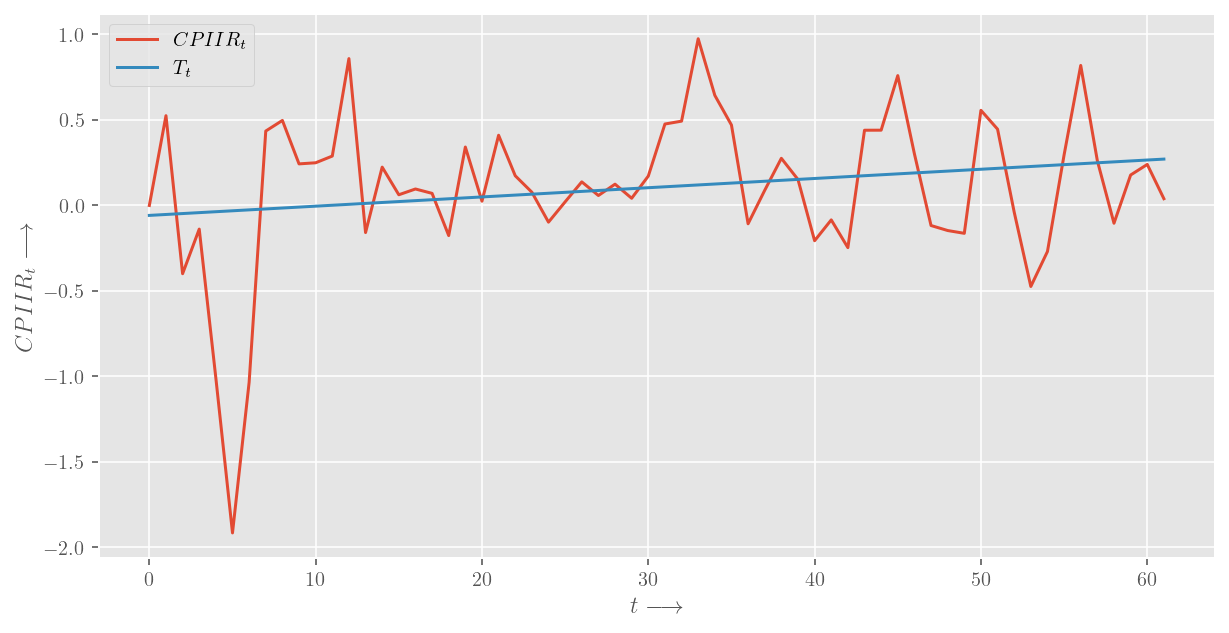

In [79]:
plt.plot(y_train, label=r'$CPI IR_t$')
plt.plot(reg.predict(X_train), label = r'$T_t$')


plt.xlabel(r'$t \longrightarrow$')
plt.ylabel(r' $ CPI IR_t \longrightarrow$')
plt.legend()

plt.show();

In [80]:
test_cpi['residual'] = y_test - reg.predict(X_test)
train_cpi['residual'] = y_train - reg.predict(X_train)

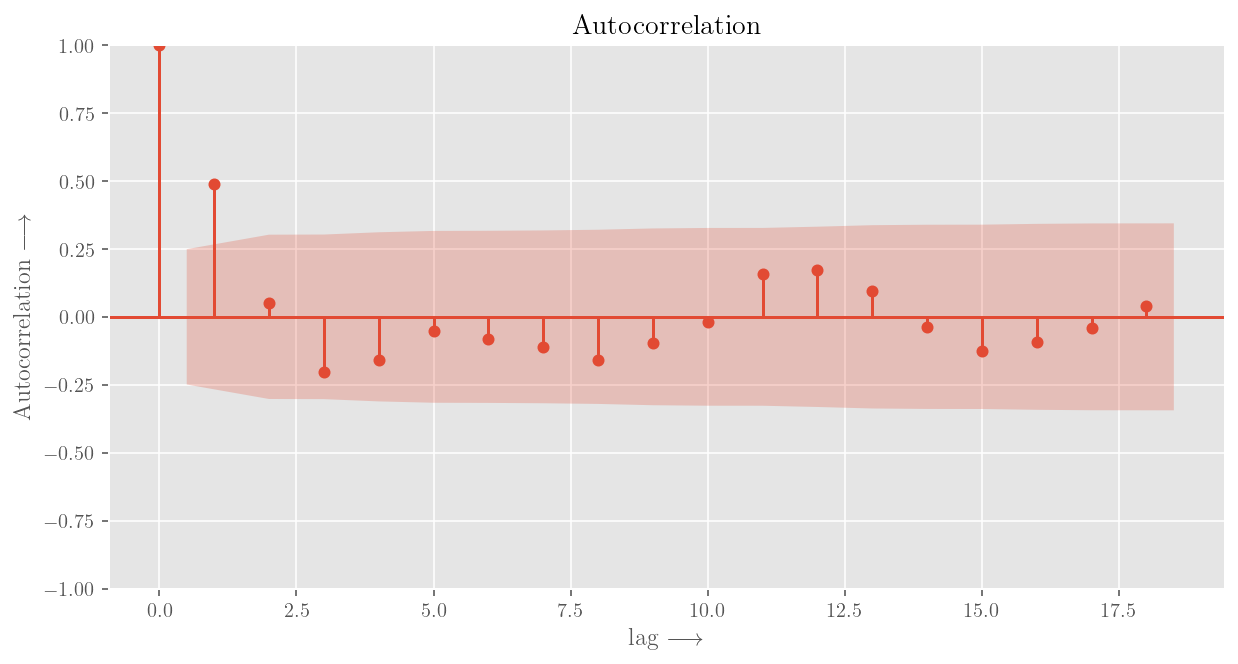

In [81]:
plot_acf(train_cpi['residual'])

plt.ylabel(r'Autocorrelation $\longrightarrow$')
plt.xlabel(r'lag $\longrightarrow$')
plt.show()

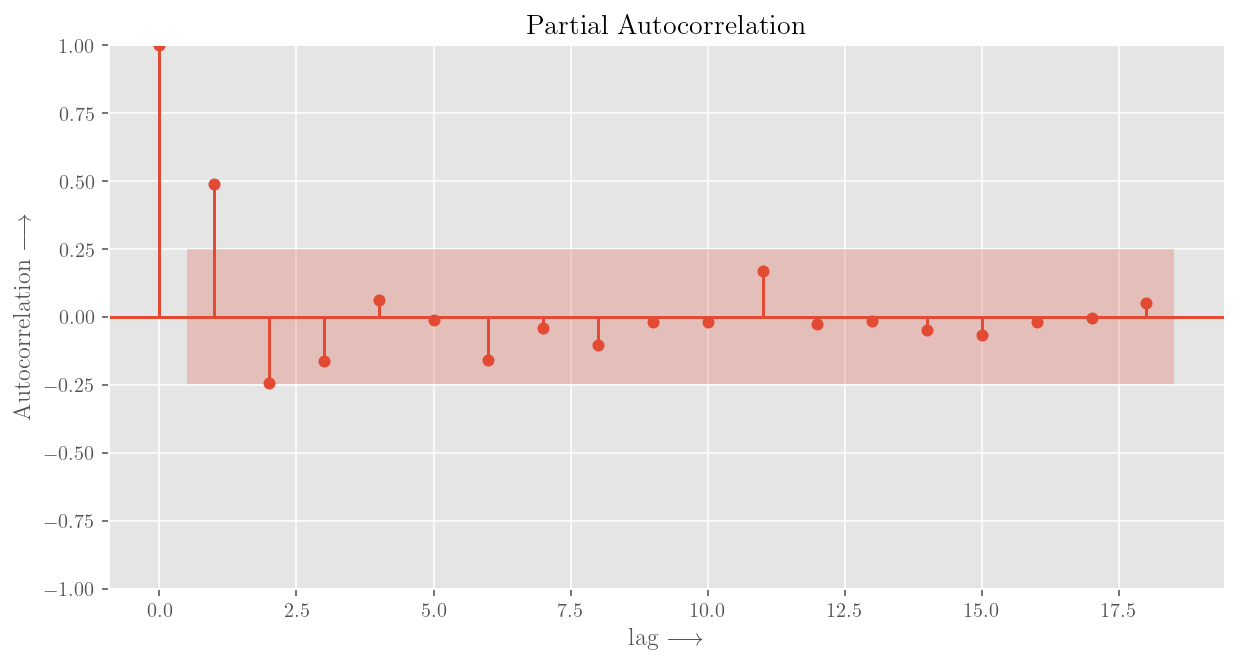

In [82]:
plot_pacf(train_cpi['residual'], method='ywm',)

plt.ylabel(r'Autocorrelation $\longrightarrow$')
plt.xlabel(r'lag $\longrightarrow$')
plt.show()

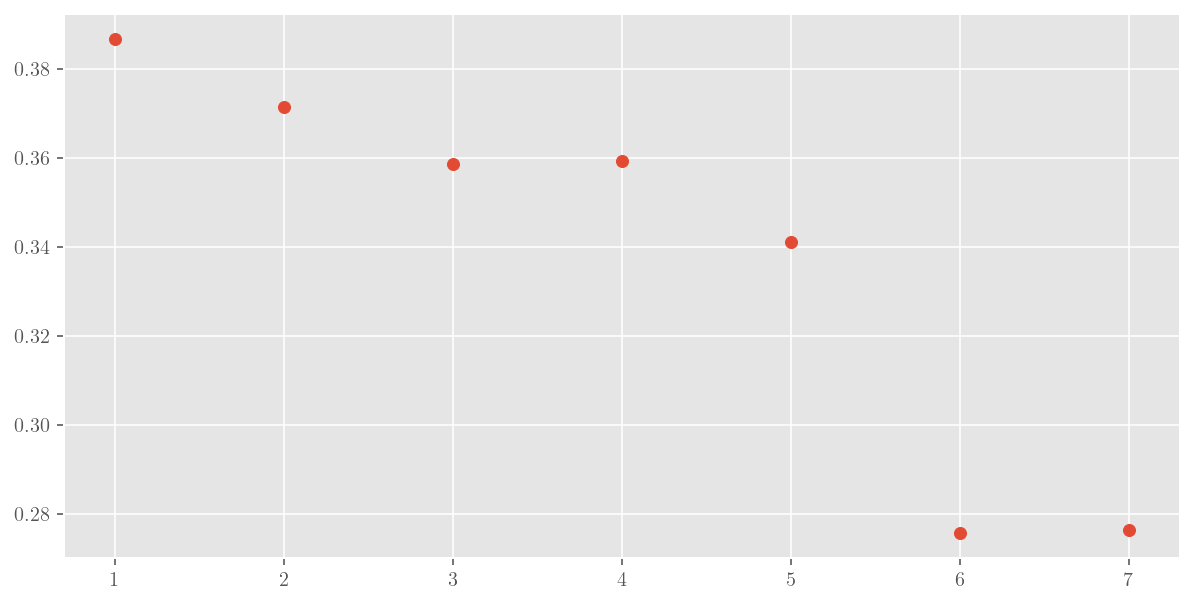

In [83]:
rmse_train = []

for n in range(1, 8):
    model = AutoReg(train_cpi['residual'],
                    lags=n,
                    trend='n' # no trend
                   )
    model_fit = model.fit()
    predictions = model_fit.predict()
    rmse = (mean_squared_error(train_cpi['residual'][n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

plt.scatter(np.arange(1, 8), rmse_train);

In [72]:
rmse_train

[0.3866399010822872,
 0.3714085269929611,
 0.3586314587992464,
 0.3592375452984763,
 0.3410662691087745,
 0.27573848325671496,
 0.27647040657594885]

### <i> __5.1.iv (3 points)__
<i>Description of the final model; computation and plots of the 1 month-ahead forecasts for the validation data. In your plot, overlay predictions on top of the data. </i>
    
#### **Solution:** 
The $t^{th}$  term of  $AR(2)$ model is given by,
\begin{equation}
    X_{t}=\phi _{1}X_{{t-1}}+\varepsilon _{t}.
\end{equation}
<h5> 1. Fitting Autoregressive model of order 2 

In [84]:
model = AutoReg(train_cpi['residual'], lags=2, trend='n')
model_fit = model.fit()
coef = model_fit.params
coef

residual.L1    0.605783
residual.L2   -0.244036
dtype: float64

The model is given by,
\begin{equation}
X_{t}=0.489175X_{{t-1}}-0.002812
\end{equation}

<h5> 2. Computation of 1-month ahead forecast for validation set

In [85]:
# take one residual from the training set for the first prediction in test set
residuals = train_cpi['residual'][-2:].append(test_cpi['residual']).tolist()
pred = []

for i in range(2, len(residuals)):
    pred.append(coef[0]*residuals[i-1] +  coef[1]*residuals[i-2])


In [86]:
test_cpi['trend'] = reg.predict(X_test)

test_cpi['predictions'] = pred + test_cpi['trend']

<h5> 3. Plot of 1-month ahead forecast for validation set

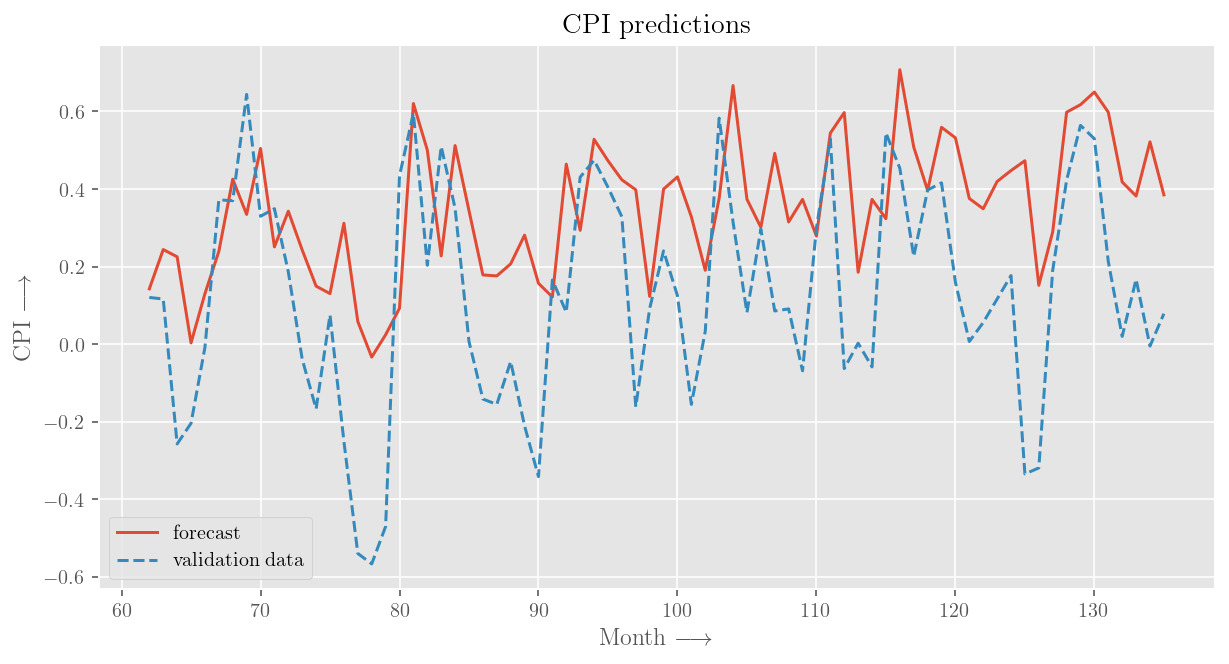

In [87]:
plt.plot(test_cpi['predictions'], label='forecast')
plt.plot(test_cpi['MIR'],'--', label='validation data' )
plt.xlabel(r'Month $\longrightarrow$')
plt.ylabel(r' CPI $\longrightarrow$')
plt.title('CPI predictions')

plt.legend()
plt.show();

In [88]:
mean_squared_error(test_cpi['MIR'], test_cpi['predictions'], squared=False)

0.32182858915359785

### <i> __5.2 (3 points)__
<i>Which $AR(p)$ model gives the best predictions? Include a plot of the $RMSE$ againt different lags $p$ for the model. </i>
    
#### **Solution:** 
<h5> 1. Compute the RMSE for p ranging from 1 to 9.

In [22]:
RMSE = []

for p in range(1, 10):
    model = AutoReg(train_cpi['residual'], lags=p)
    model_fit = model.fit()
    coef = model_fit.params
    
    # include the last p residuals from training set
    residuals = np.array(train_cpi['residual'][-p:].append(test_cpi['residual']).tolist())
    pred = []
    
    for i in range(len(residuals)-p):
        # last p residuals
        p_residuals = np.flip(residuals[i: i+p])
        
        # prediction
        pred.append( coef[0] + coef[1:].T @ p_residuals)
        
    # add back the removed trend 
    pred += test_cpi['trend']
    
    RMSE.append(np.sqrt(mean_squared_error(test_cpi['MIR'], pred)))
    
    print(f'p: {p} RMSE: {RMSE[-1]}')


p: 1 RMSE: 0.2980077154938654
p: 2 RMSE: 0.3141406463053553
p: 3 RMSE: 0.34023594686908404
p: 4 RMSE: 0.3246996322125319
p: 5 RMSE: 0.3376394570714855
p: 6 RMSE: 0.4248913275667196
p: 7 RMSE: 0.4662376796430866
p: 8 RMSE: 0.4013380822238405
p: 9 RMSE: 0.45422517775033144


p=1 produces the best predictions

<h5> 2. Plot the RMSE for p ranging from 1 to 9.

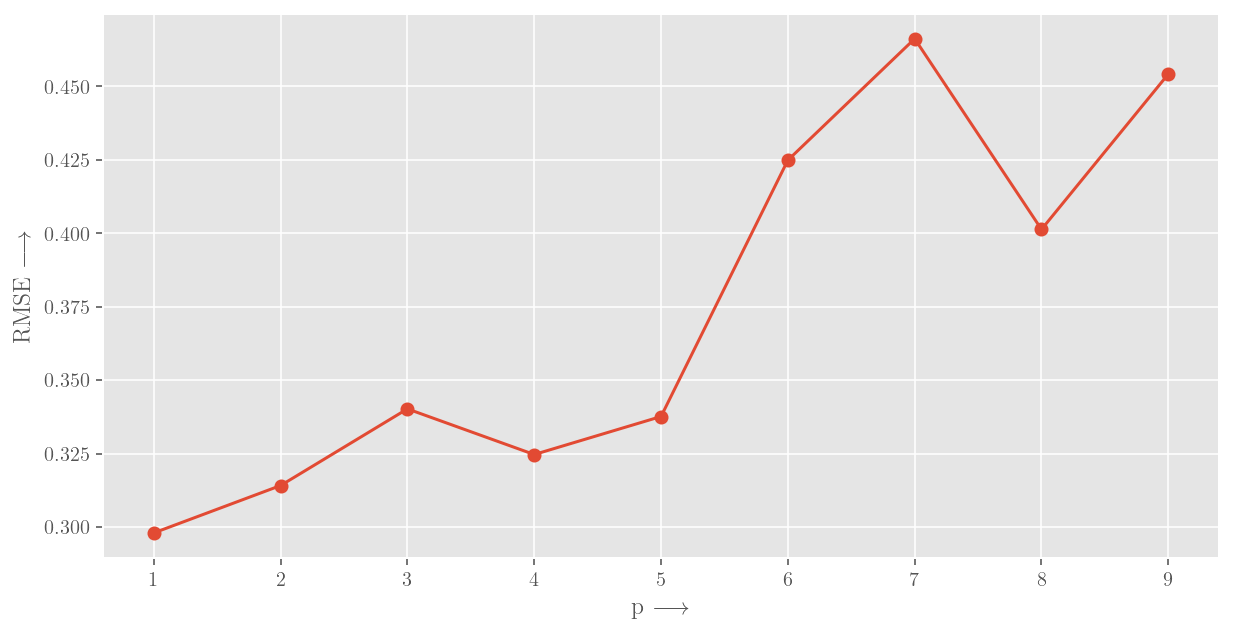

In [23]:
plt.plot([i for i in range(1, 10)], RMSE,'o-')
plt.xlabel(r'p $\longrightarrow$')
plt.ylabel(r'RMSE $\longrightarrow$')

plt.show();

## 6. External Regressors and Model Improvements

Next, we will include monthly $\text {BER}$ data as an external regressor to try to improve the predictions of inflation rate. Here we only consider to add one BER term in the AR(p) model of CPI inflation rate. In specific, we model the CPI inflation rate $X_t$ by
\begin{equation}
X_ t = \sum _{i=1}^ p \phi _ i X_{t-i} + \psi Y_{t-r} + W_ t,
\end{equation}
where $Y_ t$ is the $\text {BER}$ inflation rate at time $t$, $r\geq 0$ is the lag of $\text {BER}$ rate w.r.t. CPI rate, and $W_ t$ is white noise.

### <i> __6.1 (4 points)__ External Regressors
<i>Plot the cross correlation function between the $\text {CPI}$ and $\text {BER}$ inflation rate, by which find $r$, i.e., the lag between two inflation rates. (As only one external regressor term is involved in the model, we only consider the peak in the CCF plot.)</i>
    
#### **Solution:** 
<h5> 1. Compute monthly $\text {BER}$ inflation rate

In [89]:
# load csv as a DataFrame
ber = pd.read_csv('T10YIE.csv')

# convert date column datatype to datetime
ber['DATE'] = pd.to_datetime(ber['DATE'], format='%Y/%m/%d')

# set date column as index
ber= ber.set_index('DATE')

# resample data by month 
ber_monthly_all = ber.resample('M').mean()

ber_monthly_all.index = ber_monthly_all.index.to_period('M')

ber_monthly_all['MIR'] = ((ber_monthly_all['T10YIE']/100+1)**(1/12)-1)*100

ber_monthly = ber_monthly_all[ber_monthly_all.index >= cpi_monthly.date.min()]

# reset indices to integers 
ber_monthly = ber_monthly.reset_index()

ber_monthly[ber_monthly['DATE'] == '2013-02']

,DATE,T10YIE,MIR
55,2013-02,2.554737,0.210442


In [90]:
# split into train and test data
train_ber =  ber_monthly[ber_monthly['DATE'] < '2013-09-01'].copy()
test_ber =  ber_monthly[ber_monthly['DATE'] >= '2013-09-01'].copy()

<h5> 2. Plot $\text{BER}$ and $\text{X}_t$ </h5>
    We can see that both $\text{BER}_t$ and $\text{X}_t$ are related. $\text{X}_t$ follows $\text{BER}_t$ by a small lag.

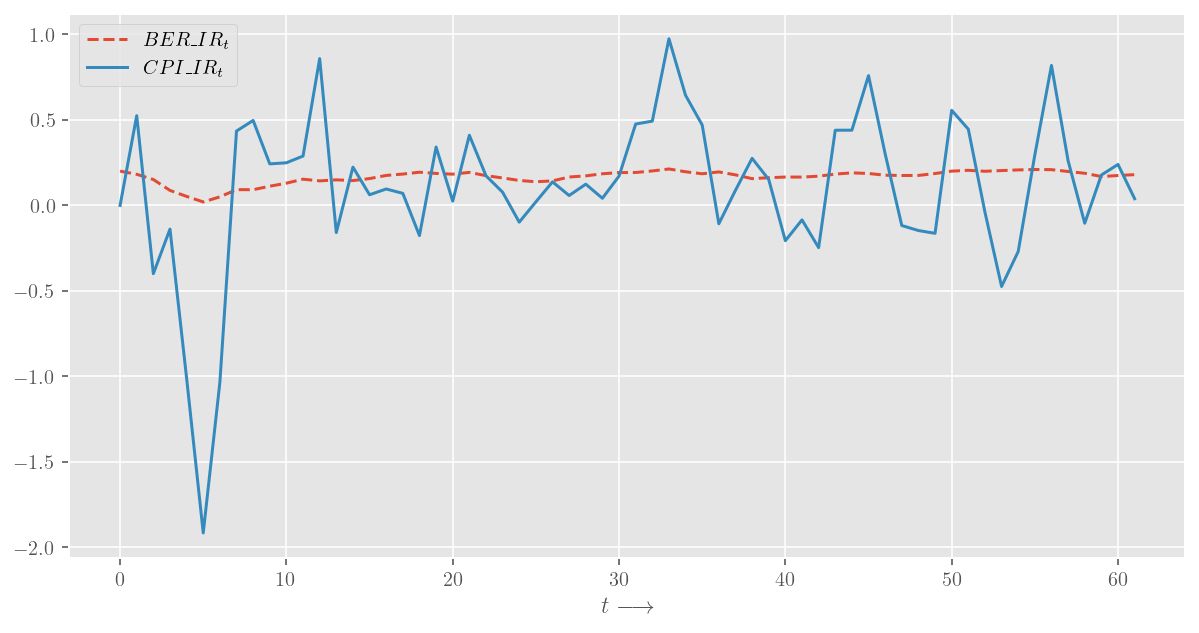

In [91]:
# plot BER upto September 2013
plt.plot(train_ber['MIR'],'--', label=r'$BER\_IR_t$', )
plt.plot(train_cpi['MIR'], label=r'$CPI\_IR_t $')


#labels
plt.xlabel(r'$t \longrightarrow$')
plt.legend()

plt.show();

<h5> 3. Plot the cross correlation lag between $\text {CPI}$ and $\text {BER}$ inflation rates

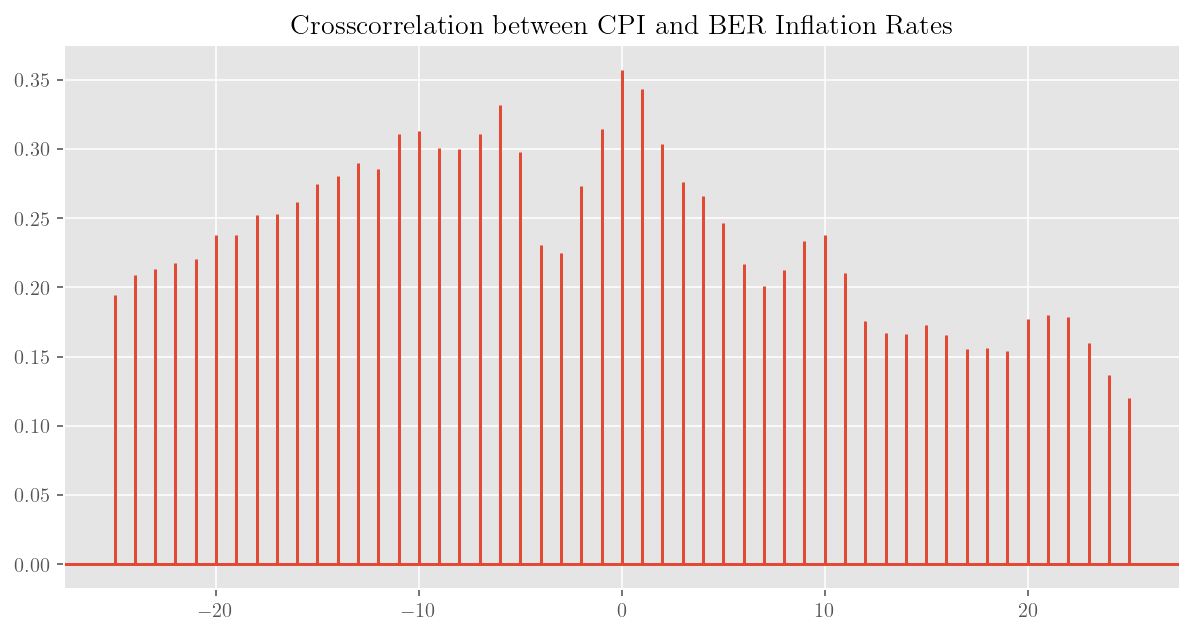

In [95]:
from statsmodels.tsa.stattools import ccf
plt.xcorr(train_ber['MIR'][1:], train_cpi['MIR'][1:], maxlags = 25)
plt.title('Crosscorrelation between CPI and BER Inflation Rates')
plt.show()

<h5> 4. Find r: </h5>
I chose to look at the correlation lag as r=0 as it has the highest cross correlation

### <i> __6.2 (3 points)__ External Regressors
<i>Fit a new $\text {AR}$ model to the $\text {CPI}$ inflation rate with these external regressors and the most appropriate lag. Report the coefficients. Python Tip: You may use</i> `sm.tsa.statespace.SARIMAX`.
#### **Solution:** 
<h5> 1. Fitting Autoregressive model of order p = 2 with enternal regressor of lag r = 0

In [121]:
def ext_reg_gen(r, df):
    """
    given a lag r select the corresponding external regressor
    """
    ext_reg = ber_monthly_all[ber_monthly_all.index >= df.date.min()-r]
    ext_reg = ext_reg[ext_reg.index <= df.date.max()-r]
    ext_reg = ext_reg.set_index(df.index)
    return ext_reg['MIR']

In [150]:
train_cpi['exreg'] = ext_reg_gen(6, train_cpi)
ex_model = SARIMAX(endog=train_cpi['residual'][2:],exog=train_cpi['exreg'][2:], order=(1, 0, 0))
ex_model = ex_model.fit()
params = ex_model.params
params

exreg    -0.388198
ar.L1     0.510707
sigma2    0.140474
dtype: float64

Therefore the model is given by,

\begin{equation}
X_t = 0.484882X_{t-1} + X_{t-2} + 0.360801Y_{t-3} 
\end{equation}

<h5> 2. Computation of 1-month ahead forecast for validation set

In [151]:
# take two residuals from the training set for the first two predictions in test set
residuals = train_cpi['residual'][-2:].append(test_cpi['residual']).tolist()
pred = []

for i in range(2, len(residuals)):
    pred.append(params[1]*residuals[i-1])

pred += ext_reg_gen(0, test_cpi) * params[0] 
test_cpi['predictions_exreg'] = pred + test_cpi['trend']

test_cpi['predictions_exreg']

62     0.089487
63     0.132080
64     0.133220
65    -0.054836
66    -0.026967
         ...   
131    0.536207
132    0.375431
133    0.284829
134    0.362619
135    0.278142
Name: predictions_exreg, Length: 74, dtype: float64

<h5> 3. Plot of 1-month ahead forecast for validation set

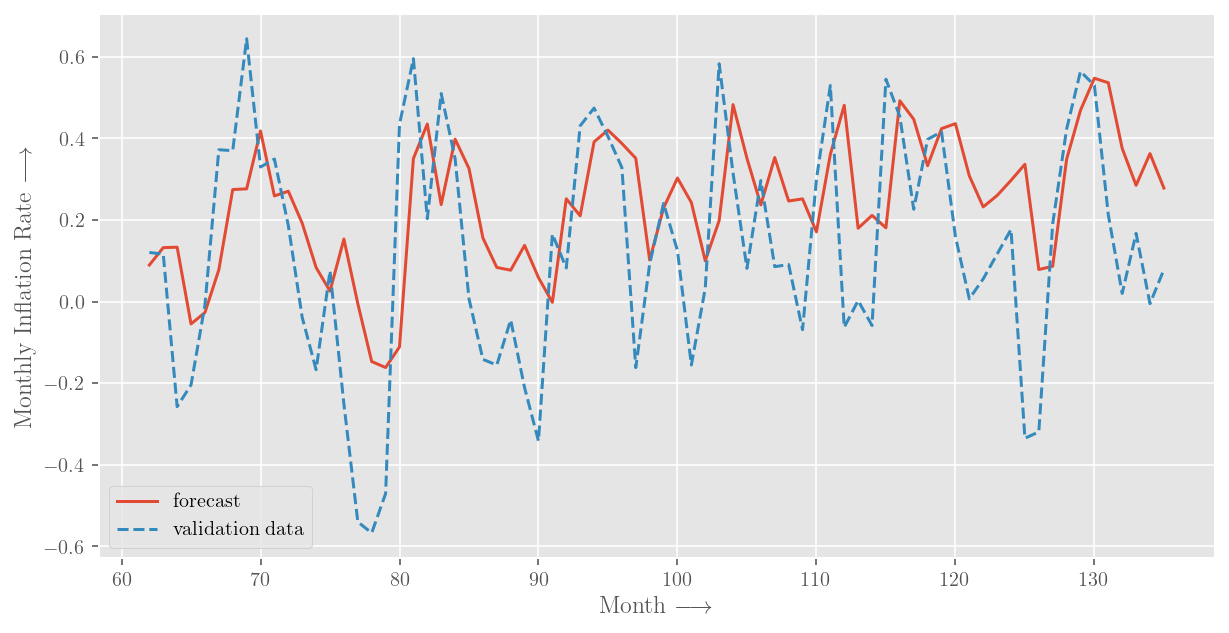

In [152]:
plt.plot(test_cpi['predictions_exreg'], label='forecast')
plt.plot(test_cpi['MIR'],'--', label='validation data' )
plt.xlabel(r'Month $\longrightarrow$')
plt.ylabel(r' Monthly Inflation Rate $\longrightarrow$')

plt.legend()
plt.show();

### <i> __6.3 (1 points)__ External Regressors
<i>Report the mean squared prediction error for 1 month ahead forecasts.</i>
#### **Solution:** 

In [153]:
rmse = mean_squared_error(test_cpi['MIR'], test_cpi['predictions_exreg'], squared=False)

print(f'RMSE : {rmse}')

RMSE : 0.26631320044005014


### <i> __6.3 (5 points)__ Improving your Model
<i>What other steps can you take to improve your model from part III? What is the smallest prediction error you can obtain? Describe the model that performs best. You might consider including MA terms, adding a seasonal AR term, or adding multiple daily values (or values from different months) of $\text {BER}$ data as external regressors.</i>
#### **Solution:** 
    
    In the following code, I have trained, predicted and evaluated different models with various lags. The output dataframe contains the results

<h5> 1. Comapring p-values, BIC of the models with external regressors of different lags $r$

In [154]:
stats = pd.DataFrame(columns = ['r', 'coef_exreg' ,'coef_lag1', 'p_value_exreg', 'BIC', 'RMSE'])
pred_cpi = pd.DataFrame(columns= [i for i in range(10)])

for r in range(0, 10):
    
    # ----------TRAIN MODEL------------
    
    ex_model = SARIMAX(endog=train_cpi['residual'][2:],exog=ext_reg_gen(r, train_cpi)[2:], order=(1, 0, 0))
    ex_model = ex_model.fit()
    
    # ----------PREDICTIONS------------
    
    # take two residuals from the training set for the first two predictions in test set
    residuals = train_cpi['residual'][-1:].append(test_cpi['residual']).tolist()
    pred = []
    params = ex_model.params

    
    for i in range(1, len(residuals)):
        # add the autoregressive part
        pred.append(params[1]*residuals[i-1])
    
    # add the external regressor part
    pred += ext_reg_gen(r, test_cpi) * params[0]
    
    # add the trend part
    pred_cpi[r] = pred + test_cpi['trend']
    
    # ---------- EVALUATE MODEL ------------
    
    rmse = mean_squared_error(test_cpi['MIR'], pred_cpi[r] , squared=False)
    
    stats.loc[r] = [r, 
                    ex_model.params[0], 
                    ex_model.params[1], 
                    np.round(ex_model.pvalues[0], 5), 
                    ex_model.bic,
                    np.round(rmse, 5)
                   ]
    
stats

,r,coef_exreg,coef_lag1,p_value_exreg,BIC,RMSE
0,0.0,0.317967,0.516475,0.64615,65.269591,0.32370
1,1.0,0.280620,0.518519,0.68849,65.339158,0.31997
2,2.0,-0.091518,0.515649,0.89478,65.551956,0.28600
3,3.0,-0.311601,0.517281,0.63082,65.275302,0.26814
4,4.0,-0.435317,0.517265,0.49976,64.983379,0.25983
5,5.0,-0.333800,0.510022,0.59115,65.221591,0.26769
6,6.0,-0.388198,0.510707,0.52138,65.095427,0.26393
7,7.0,-0.404579,0.512085,0.53211,65.058525,0.26278
8,8.0,-0.277713,0.510413,0.67962,65.335173,0.27178
9,9.0,-0.328644,0.514469,0.61928,65.241517,0.26781


* Generally the p-values are high indicating that there is not much correlation between BER and CPI inflation rates. 
* Lag $r = 4$ has the lowest prediction error among all other lags. 

RMSE  = 0.27482 , for lag $r = 4$

<h5> 2. Plotting 1-month ahead forecast for external regressor lag $r = 4$

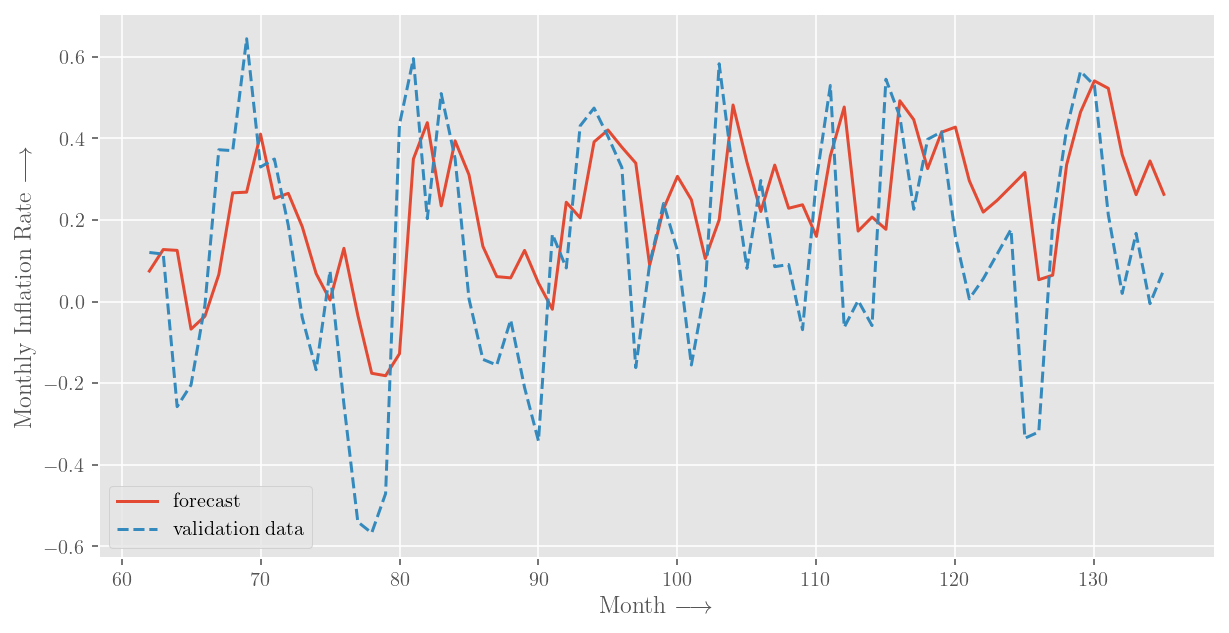

In [155]:
plt.plot(pred_cpi[4], label='forecast')
plt.plot(test_cpi['MIR'],'--', label='validation data' )
plt.xlabel(r'Month $\longrightarrow$')
plt.ylabel(r' Monthly Inflation Rate $\longrightarrow$')

plt.legend()
plt.show();